# **Features Extractor - CIFAR10 on ResNet50 - using TensorFlow with Keras**

In this part, we take pre-trained model **VGG16** and using **Tranfer Learning** technique to train it on **CIFAR10** dataset.

We performs **Fine Tuning** using **TensoFlow** with **Keras** by **Python**.

1. Download and Explore our data
2. Load our pretrained VGG16 Model
3. Train a  Classifier using those features
4. Model Performance Analysis
5. Save the Model 

We're taking the output of the last CONV-POOL layer (see below). 

The output shape at this layer is **7 x 7 x 512**

![feat_extraction](https://appliedmachinelearning.files.wordpress.com/2021/05/ef54e-vgg16.png?w=612&zoom=2)
Image referenced from [here](https://appliedmachinelearning.blog/2019/07/29/transfer-learning-using-feature-extraction-from-trained-models-food-images-classification/)

## **1. Import Laberies, Load Dataset and Preprocesse the data**

#### **Import laberies**

In [ ]:
# importing tensorflow and Keras for doing ML
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### **Loading our CIFAR-10 Dataset and preprocess it images**


![](https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

#### **Loading dataset and preprocess the data**

In [ ]:
# Loads the CIFAR dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Display our data shape/dimensions
print("Data Set:")
print('train samples: ', x_train.shape[0])
print('test samples: ', x_test.shape[0])
print('x_train shape:', x_train.shape)

x_train = np.array([cv2.resize(img, (227, 227)) for img in x_train[:10000]])
x_test = np.array([cv2.resize(img, (227, 227)) for img in x_test[:2000]])
y_train = y_train[:10000]
y_test = y_test[:2000]

print("\nResizing images..")
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Now we one hot encode outputs
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

np.random.seed(1000)

Data Set:
train samples:  50000
test samples:  10000
x_train shape: (50000, 32, 32, 3)

Resizing images..
x_train shape: (10000, 227, 227, 3)
y_train shape: (10000, 1)
x_test shape: (2000, 227, 227, 3)
y_test shape: (2000, 1)


#### **Display some images from our dataset**

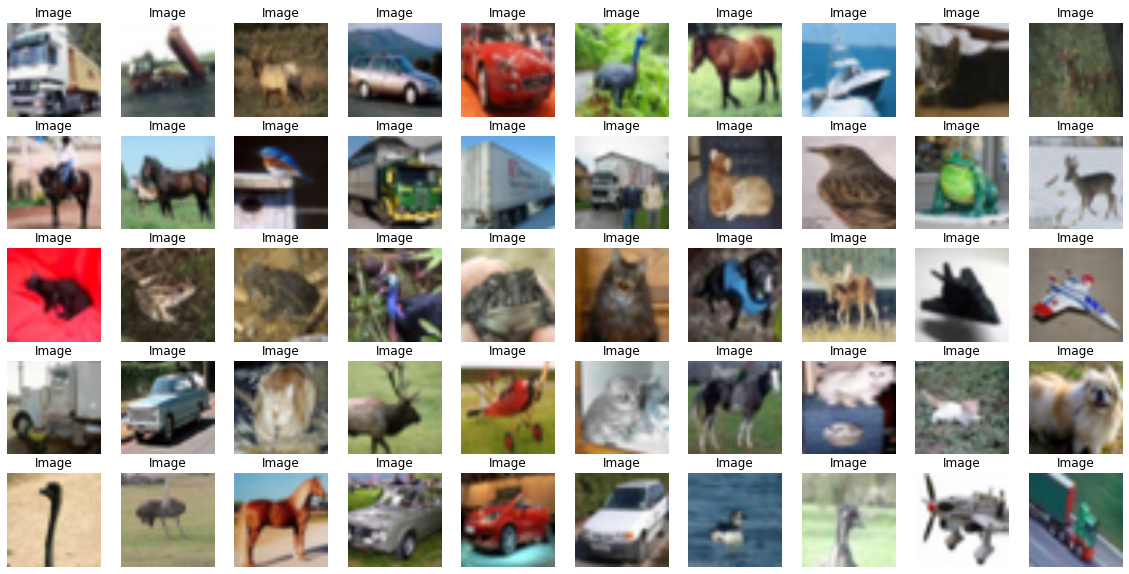

In [ ]:
# Define figure size
plt.figure(figsize=(20,10))

# Define number of images to display
num_of_images = 50


# iterate index from 1 to 51 to show the first 50 images from training dataset
for index in range(1, num_of_images +1):
  plt.subplot(5, 10, index).set_title(labels[np.argmax(y_train[index])])
  plt.axis('off')
  plt.imshow(x_train[index])

## **2. Build The Model**

#### **Load pre-trained VGG16 Model**

In [ ]:
# Load VGG16 model without the top and define input shape to (224 X 224 X 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(227,227,3))

# Print the model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### **Freezing the base model layers**

In [ ]:
# Create ResNet50 model as type Sequential
last_layer = base_model.get_layer('block5_pool')
output = last_layer.output
input = base_model.input
vgg_model = Model(input, output)

# Freezing the train layers in the model
for layer in vgg_model.layers:
  layer.trainable = False

# Print the model summary and type
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### **Build our model and fit it to our data set**

In [ ]:
# Create Sequential type model
model = Sequential()

# Add the VGG16 base model to into it
model.add(vgg_model)

# Build the last layers on the base model and fit it to our dataset 
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, 'softmax'))

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
optimizer = Adam(0.0001)
loss_function = 'categorical_crossentropy'
model.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss', min_delta=0, 
                   patience=2, verbose=1, mode='auto')

# Print the model type and summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

## **3. Train The Model**

In [ ]:
# Make the model trainable
model.trainable = True
batch_size = 64
epochs = 25

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks = [es])

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
157/157 [==============================] - 79s 458ms/step - loss: 1.9820 - accuracy: 0.3152 - val_loss: 1.3068 - val_accuracy: 0.5930
Epoch 2/25
157/157 [==============================] - 69s 437ms/step - loss: 1.2992 - accuracy: 0.5535 - val_loss: 1.0067 - val_accuracy: 0.6780
Epoch 3/25
157/157 [==============================] - 69s 437ms/step - loss: 1.0771 - accuracy: 0.6333 - val_loss: 0.8778 - val_accuracy: 0.7085
Epoch 4/25
157/157 [==============================] - 69s 437ms/step - loss: 0.9313 - accuracy: 0.6770 - val_loss: 0.8016 - val_accuracy: 0.7355
Epoch 5/25
157/157 [==============================] - 69s 437ms/step - loss: 0.8353 - accuracy: 0.7114 - val_loss: 0.7484 - val_accuracy: 0.7520
Epoch 6/25
157/157 [==============================] - 78s 497ms/step - loss: 0.7753 - accuracy: 0.7326 - val_loss: 0.7184 - val_accuracy: 0.7620
Epoch 7/25
157/157 [==============================] - 69s 440ms/step - loss: 0.7249 - accuracy: 0.7553 - val_loss: 0.6902 - val_ac

## **4. Model Performance Analysis**

#### **Ploting our Loss and Accuracy Charts**

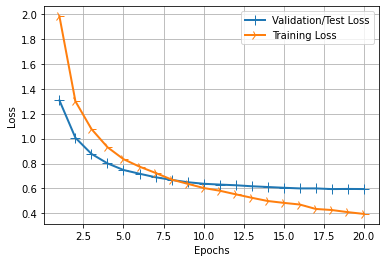

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

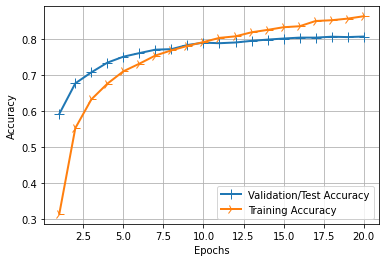

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#### **Creating our Confusion Matrix**


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

x_test = x_test.reshape(10000, 227, 227, 1) 
y_pred = np.argmax(model_da.predict(x_test), axis=-1)

print(confusion_matrix(y_test, y_pred))

In [ ]:
sample_test = x_test

plt.figure(figsize=(8, 12))

for cel in misclassified_indices:
    index = misclassified_indices[index]
    image = x_test[index]
    label = labels[y_test[index]]
    predicted = labels[y_pred[index]]
    plt.subplot(6, 3, cel+1)
    plt.imshow(img)
    plt.xlabel("Label: " + label + "Predicted: " + predicted)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
target_names = list(range(0,10))
conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat, target_names)

#### **Let's look at our per-class accuracy**

In [ ]:
# Per-class accuracy
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

for (i, classAccuracy) in enumerate(class_accuracy):
    print(f'Accuracy for {labels[i]} : {classAccuracy:.3f}%')

#### **Visualizing the Images Our Model Misclassified**

In [ ]:
import numpy as np

# We reshape our test data
print(x_test.shape)
x_test = x_test.reshape(1000, 227, 227, 3) 
print(x_test.shape)

# Get the predictions for all 10K samples in our test data
print("Predicting classes for all 10,000 test images...")
pred = np.argmax(model_da.predict(x_test), axis=-1)
print("Completed.\n")

# Use numpy to create an array that stores a value of 1 when a misclassification occurs
result = np.absolute(y_test - pred)
misclassified_indices = np.nonzero(0 < result)

#  Display the indices of mislassifications
print(f"Indices of misclassifed data are: \n{misclassified_indices}")
print(len(misclassified_indices[0]))

In [ ]:
i = 0
plt.figure(figsize=(10, 15))

for cel in misclassified_indices[0]:

    index = misclassified_indices[0][i]
    image = x_test[index]
    label = labels[y_test[index][0]]
    predicted = labels[y_pred[index]]
    plt.subplot(6, 3, i+1)
    plt.imshow(image)
    plt.xlabel("Label: " + label + "   Predicted: " + predicted)
    i +=1
    if i == 12:
      break

plt.tight_layout()
plt.show()

## **5. Save The Model**

In [ ]:
# model.save("cifar10_VGG16_Fine_Tuning_80_Accuracy.h5")
print("Model Saved")

Model Saved


#### **Let's look at our per-class accuracy**